# $\Delta \eta_{hh}$ cut

**Motivation** In all of the summary plots that we've been making, it's become *quite* obvious that we have an issue with the high $|\cos \Theta^*|$ region when cutting on $\Delta \eta_{hh}$. To remedy this, Michael proposed categorizing in the same variable that we're cutting in, which seemed like a reasonable idea, so I'm going to *try it out*!!

In [69]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare
from scipy.stats import norm 
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text


os.sys.path.append('../Flow-Models')
from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Visualize the marginals for $\Delta \eta_{hh}$ for this cut

In [70]:
prodTag = 'FEB20'
ntag = 2
subDir = 'data16_PFlow-FEB20-5jets'
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'

nSeeds = 250
varTag = 'HC vars'

In [71]:
H_dict = {
    'HH vars': 16,
    'HC vars': 32
}

col_dict = {
    'HH vars': ['log_m_hh_cor2','absCosThetaStar'],
    'HC vars': ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh']
}

In [72]:
lr = .001
L, H = 5, H_dict[varTag]
i = 0

cols = col_dict[varTag]
colTag = '_'.join(cols)

beta = 1e-3

In [145]:
reload=False

p, beta = .01, 1e-3
nb,r = 50,(250,1250)

nPreds = 10

r5Seeds_hists      = {}
r5Seeds_hists_m_hh = {}
r5Seeds_hists_cs   = {}
r5Seeds_hists_deta = {}

# Get the data
tag = f'_SM_2b_p_{p}'
di = data(5, 16, prodTag, tag, ntag, s)

mi = (di.df.abs_deta_hh < 1.5)
di.mlPrepare(mi, cols, N=-1)
df = di.df
SR = (df.kinematic_region==0) & mi
nSeeds = 250

nEvts = di.X_SR.shape[0]

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


In [74]:
varTag

'HC vars'

In [75]:
di.df.columns

Index(['entry', 'run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'ml_j0_Db',
       'ml_j1_Db', 'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db', 'HT', 'MDR', 'MDpT',
       'max_prob', 'm_hh_cor2', 'log_m_hh_cor2', 'abs_deta_hh',
       'absCosThetaStar', 'log_pT_h1', 'log_pT_h2', 'dphi_hh', 'log_dphi_hh',
       'train', 'val', 'test'],
      dtype='object')

In [96]:
dfi.columns

Index(['m_h1', 'm_h2', 'log_pT_h1', 'log_pT_h2', 'eta_h2', 'eta_h1',
       'log_dphi_hh', 'pT_h1', 'pT_h2', 'dphi_hh', 'm_hh', 'm_hh_cor2',
       'absCosThetaStar', 'pt_hh', 'abs_deta_hh'],
      dtype='object')

In [97]:
csMax = .9
detaMax = 1.4

In [148]:
r = (0,1.75)

for seed in tqdm(range(nSeeds)):

    # Load in the R-NVP
    seedTag = f'_seed{seed}' if seed != 10 else ''
    ri = RealNVP(f'{subDir}{tag}_2b_detaCut{seedTag}', lr, beta, cols, 0, L, H,
                 load_model=True,modelBaseDir='../Flow-Models/models',debug=False)
    filename = f'{ri.modelDir}/df_SR.h5'
    key = f'p_{p}_beta{beta:.0e}_seed{seed}'
    
    if reload:
        rpi = RealNVP_Plots(ri, save=False)

        if varTag == 'HH vars':
            dfi = rpi.medianMarginals(di.X_SR, di.Y_SR, di, nPreds=nPreds, plot=False)
        
        else:
            dfi = rpi.pred_hh(di.X_SR, di.Y_SR, di.scalar, SR, df, nPreds=nPreds, cols=cols, plot=False)
        
        
        # Swap levels and save the seed
        dfi = dfi.swaplevel()
        idx = pd.MultiIndex.from_product([range(nEvts),[seed],range(nPreds)],
                                         names=['events','seeds','samples'])
        dfi.index = idx
        
        dfi.to_hdf(filename,key='df',format='table')
    else:
        dfi = pd.read_hdf(filename,key='df')
      
    # Calc the new var we want to plot
    dfi['abs_deta_hh'] = np.abs(dfi.eta_h1-dfi.eta_h2)
    
    
    ms = [np.ones_like(dfi.index).astype(bool), dfi.absCosThetaStar < csMax, dfi.abs_deta_hh < detaMax]
    for t, m in zip(['','_csCut','_detaCut'],ms):
    
        r5Seeds_hists[key+t]      = np.histogram(dfi.loc[m,'m_hh_cor2'], nb, (250,1250))[0] / nPreds
        r5Seeds_hists_m_hh[key+t] = np.histogram(dfi.loc[m,'m_hh'], nb, (200,1200))[0] / nPreds
        r5Seeds_hists_cs[key+t]   = np.histogram(dfi.loc[m,'absCosThetaStar'], nb, (-0.05,1.05))[0] / nPreds
        r5Seeds_hists_deta[key+t] = np.histogram(dfi.loc[m,'abs_deta_hh'], nb, r)[0] / nPreds
    
# 2b
n_2b,d = np.histogram(df.loc[SR,'m_hh'],nb,(200,1200)) 
r5Seeds_hists_m_hh[f'p_{p}_2b'] = n_2b

n_2b,e = np.histogram(df.loc[SR,'m_hh_cor2'],nb,(250,1250)) 
r5Seeds_hists[f'p_{p}_2b'] = n_2b

n_2b_cs,f = np.histogram(df.loc[SR,'absCosThetaStar'],nb,(-0.05,1.05)) 
r5Seeds_hists_cs[f'p_{p}_2b'] = n_2b_cs

n_2b_deta,g = np.histogram(df.loc[SR,'abs_deta_hh'],nb,r) 
r5Seeds_hists_deta[f'p_{p}_2b'] = n_2b_deta

# And now w/ the appropriate masks!!
for t, m in zip(['_csCut','_detaCut'],[df.absCosThetaStar < csMax, df.abs_deta_hh < detaMax]):

    r5Seeds_hists_m_hh[f'p_{p}_2b{t}'] = np.histogram(df.loc[SR & m,'m_hh'],           nb,(200,1200))[0]
    r5Seeds_hists[f'p_{p}_2b{t}']      = np.histogram(df.loc[SR & m,'m_hh_cor2'],      nb,(250,1250))[0]
    r5Seeds_hists_cs[f'p_{p}_2b{t}']   = np.histogram(df.loc[SR & m,'absCosThetaStar'],nb,(-0.05,1.05))[0]
    r5Seeds_hists_deta[f'p_{p}_2b{t}'] = np.histogram(df.loc[SR & m,'abs_deta_hh'],    nb,r) [0]
    

100%|██████████| 250/250 [03:50<00:00,  1.08it/s]


In [77]:
betaStr = r'$\beta$'

c0,c1 = 'thistle','darkviolet'

In [78]:
hists_deta = np.vstack([r5Seeds_hists_deta[f'p_{p}_beta{beta:.0e}_seed{s}'] for s in range(nSeeds)])

nom_deta = np.mean(hists_deta,axis=0)
std_deta = np.std(hists_deta,axis=0)

zz = np.linspace(*r,nb)

In [79]:
dfi.abs_deta_hh.min(),dfi.abs_deta_hh.max()

(5.364418029785156e-06, 2.1197855472564697)

In [80]:
z_fine = np.hstack([r[0]]+[ff for ff in g[1:-1] for i in range(2)]+[r[1]])

deta_fine = np.hstack([nn for nn in nom_deta for i in range(2)])
sig_deta_fine = np.hstack([nn for nn in std_deta for i in range(2)])

In [81]:
text = "$\mathbf{ATLAS}$ data Internal\n"
text += "2016 data FEB2020 MNT prod\n"
text += r"DL1r 77% WP, $\mathrm{\mathbb{P}}_{SM}$ w/ $|\Delta \eta_{hh}|$ < 1.5"

In [82]:
figDir_p01 = f'figures/{subDir}_SM_2b_p_0.01_2b_detaCut/rnvp_{colTag}_{L}_layers_H_{H}_lr_{lr}_{beta}_iter0/'

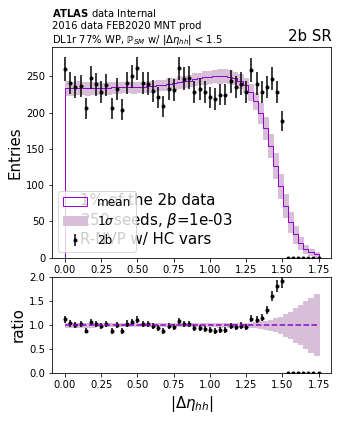

In [87]:
# Make the figure
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

# # Error bars
ax1.fill_between(z_fine,deta_fine+sig_deta_fine,deta_fine-sig_deta_fine,
                 color=c0,label='$1\sigma$')
ax2.fill_between(z_fine,(deta_fine+sig_deta_fine)/deta_fine,
                 (deta_fine-sig_deta_fine)/deta_fine,color=c0)

# 2b
ax1.errorbar(zz, n_2b_deta, np.sqrt(n_2b_deta), label='2b', fmt='.', color='k')
ax2.errorbar(zz, n_2b_deta/nom_deta, np.sqrt(n_2b_deta)/nom_deta, fmt='.', color='k',zorder=1)

# Central value
ax1.hist(zz, nb,r,color=c1,histtype='step',weights=nom_deta,label='mean')
ax2.plot(zz, np.ones_like(zz), color=c1,linestyle='--')

ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=12)
ax1.set_title('2b SR',loc='right',fontsize=15)

ax2.set_xlabel('|$\Delta \eta_{hh}|$', fontsize=15)
ax2.set_ylim(0,2)
ax2.set_ylabel('ratio',fontsize=15)

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
ax1.text(0.1, 0.05, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}\nR-NVP w/ {varTag}',
         ha='left',va='bottom',transform=ax1.transAxes,fontsize=15)

#plt.savefig(, bbox_inches='tight')

plt.show()

**Q** What if we modelled not *everything*, but j slightly looser than we're trying to cut?

It looks like the rightmost 10 bins aren't helping *anybody*... 

I.e, if we cut at $\Delta \eta_{hh}$ < 1.5 in training, try just modelling up to $\Delta \eta_{hh}$ < 1.4.

In [94]:
(1.75/50)*10

0.35000000000000003

Ok, so there are now *12* different plots that I want to make, let's try to functionify this?

Or at least do it in a for loop?

In [160]:
def marginalWithErrors(seeds_hists, tag='',nb=50, r=(0,1.75), xlabel='|$\Delta \eta_{hh}|$',title='2b SR',
                       filename=''):


    # Get the nominal values
    hists = np.vstack([seeds_hists[f'p_{p}_beta{beta:.0e}_seed{s}{tag}'] for s in range(nSeeds)])

    nom = np.mean(hists,axis=0)
    std = np.std( hists,axis=0)

    e = np.linspace(*r,nb+1)
    xx = 0.5 * ( e[1:] + e[:-1] )

    x_fine = np.hstack([r[0]]+[ee for ee in e[1:-1] for i in range(2)]+[r[1]])

    fine = np.hstack([nn for nn in nom for i in range(2)])
    std_fine = np.hstack([nn for nn in std for i in range(2)])

    
    # Make the figure
    fig = plt.figure(figsize=(11,6))
    gs = gridspec.GridSpec(3,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

    # # Error bars
    ax1.fill_between(x_fine, fine+std_fine, fine-std_fine,
                     color=c0,label='$1\sigma$')
    ax2.fill_between(x_fine, (fine+std_fine)/fine, (fine-std_fine)/fine,color=c0)

    # 2b
    n_2b = seeds_hists[f'p_{p}_2b{tag}']
    ax1.errorbar(xx, n_2b, np.sqrt(n_2b), label='2b', fmt='.', color='k')
    ax2.errorbar(xx, n_2b/nom, np.sqrt(n_2b)/nom, fmt='.', color='k',zorder=1)

    # Central value
    ax1.hist(xx, nb,r,color=c1,histtype='step',weights=nom,label='mean')
    ax2.plot(xx, np.ones_like(xx), color=c1,linestyle='--')

    
    if 'm_{hh}' in xlabel:
        ax1.set_yscale('log')
    
    ax1.set_ylabel('Entries',fontsize=15)
    ax1.legend(fontsize=12,loc='center left' if 'Delta' in xlabel else 'upper right')
    ax1.set_title(title,loc='right',fontsize=15 if len(title) < 10 else 12)

    ax2.set_xlabel(xlabel, fontsize=15)
    ax2.set_ylim(0,2)
    ax2.set_ylabel('ratio',fontsize=15)

    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
    ax1.text(0.1, 0.05, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}\nR-NVP w/ {varTag}',
             ha='left',va='bottom',transform=ax1.transAxes,fontsize=15)

    if len(filename) > 0:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()
    

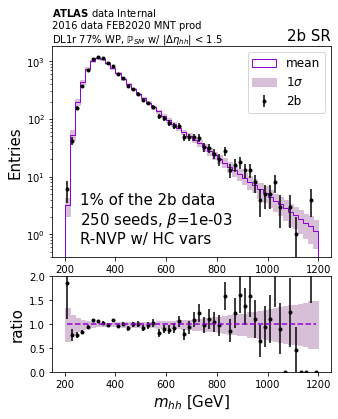

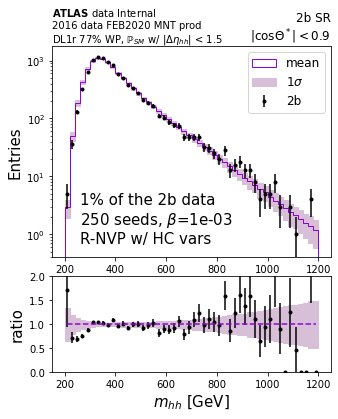

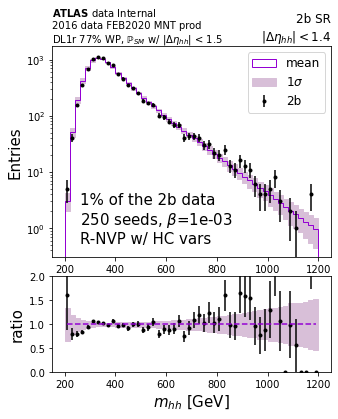

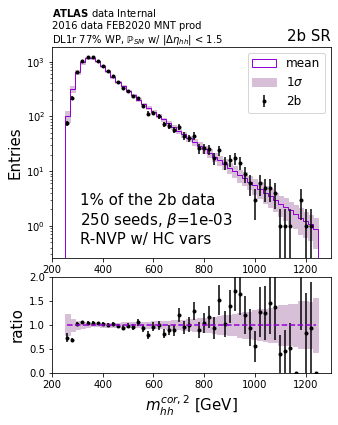

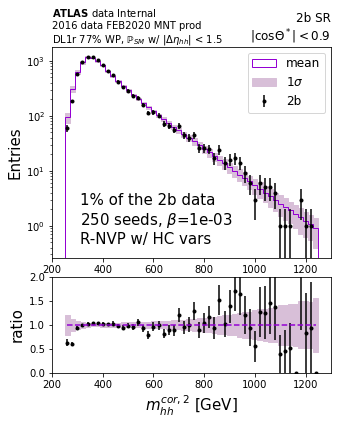

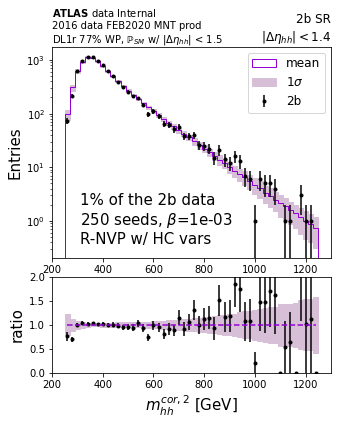

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


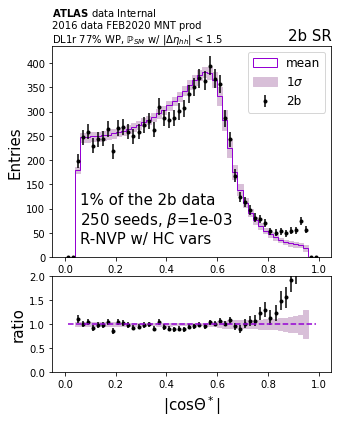

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


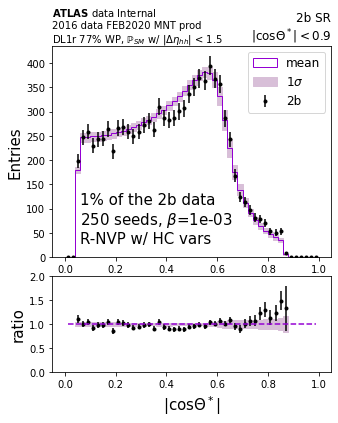

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
for histSeeds,ri,v,xlabel in zip([r5Seeds_hists_m_hh,r5Seeds_hists,r5Seeds_hists_cs,r5Seeds_hists_deta],
                                 [(200,1200),(250,1250),(0,1),(0,1.75)],
                                 ['m_hh','m_hh_cor2','absCosThetaStar','abs_deta_hh'],
                                 ['$m_{hh}$ [GeV]','$m_{hh}^{cor,2}$ [GeV]','$|\cos \Theta^*|$','$|\Delta \eta_{hh}|$']):
    for ti,title in zip(['','_csCut','_detaCut'],
                        ['2b SR','2b SR\n$|\cos \Theta^*| < 0.9$','2b SR\n$|\Delta \eta_{hh}| < 1.4$']):
        
        # Automatically infer what the filename should be!
        filename = f'{figDir_p01}/{v}_SR{ti}_mean_1sigma_250seeds.pdf'
        
        marginalWithErrors(histSeeds,ti,nb,ri,xlabel,title,filename)